In [13]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
import os
import csv

Importing Maori lexicon

http://nzetc.victoria.ac.nz/tm/scholarly/tei-legalMaoriCorpus.html#legal_maori_lexicon.

http://www.maori.info/maori_language.htm

http://tereomaori.tki.org.nz/Teacher-tools/Te-Whakaipurangi-Rauemi/High-frequency-word-lists

Removed macrons, parentheses etc from file in Sublime Text.

In [422]:
maori_lexicon = set([])

with open('../data/raw/maori_legal_lexicon.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for item in rough_list:
        for word in item:
            if (word!='' and ~word.isdigit()):
                for i in word.split(' '):
                    maori_lexicon.add(i.lower())
f.close()

with open('../data/raw/maori_lexicon.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for item in rough_list:
        for word in item:
            maori_lexicon.add(word.lower())
f.close()

#Need to remove single letters, 'no' and 'one' which are a common source of false positives            
to_remove = ['','me','no','one','a','e','i','o','u']            

for letter in to_remove:
    maori_lexicon.remove(letter)

Using a slightly edited verison of the first ~2000 from https://github.com/first20hours/google-10000-english/blob/master/20k.txt

http://www.quietaffiliate.com/free-first-name-and-last-name-databases-csv-and-sql/

In [441]:
english_lexicon = set([])

with open('../data/raw/english_lexicon_top_2000.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()
            
with open('../data/raw/CSV_Database_of_First_And_Last_Names/CSV_Database_of_First_Names.csv', 'rU') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()

with open('../data/raw/CSV_Database_of_First_And_Last_Names/CSV_Database_of_Last_Names.csv', 'rU') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())  
f.close()
            
with open('../data/raw/misclassified-as-maori.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()

english_lexicon = english_lexicon.difference(maori_lexicon)

In [249]:
print len(english_lexicon)

93040


In [147]:
def word2features(word,maori=True):
    """Returns a word length normalized vector of all letter frequencies and bigrams.
       First entry is word, second is whether it is a Maori word or not."""
    if maori == True:
        features = [word,1]
    else:
        features = [word,0]
    word_length = len(word)
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l',
                'm','n','o','p','q','r','s','t','u','v','w','y','z']
    for letter in alphabet:
        features.append(word.count(letter)/float(word_length))
    for first_letter in alphabet:
        for second_letter in alphabet:
            features.append(word.count(first_letter+second_letter)/float(word_length))
    return features

In [148]:
words = []
for word in maori_lexicon:
    words.append(word2features(word))
for word in english_lexicon:
    words.append(word2features(word,maori=False))

In [149]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l',
            'm','n','o','p','q','r','s','t','u','v','w','y','z']
column_names = ['word', 'maori_binary']
for letter in alphabet:
    column_names.append(letter)
for first_letter in alphabet:
    for second_letter in alphabet:
        column_names.append(first_letter+second_letter)

In [150]:
words_df = pd.DataFrame(words)
words_df.columns = column_names
print words_df.head()

           word  maori_binary         a    b    c    d         e    f  \
0         ainga             1  0.400000  0.0  0.0  0.0  0.000000  0.0   
1       kahore              1  0.142857  0.0  0.0  0.0  0.142857  0.0   
2         putua             1  0.200000  0.0  0.0  0.0  0.000000  0.0   
3        takahe             1  0.333333  0.0  0.0  0.0  0.166667  0.0   
4  whakaminenga             1  0.250000  0.0  0.0  0.0  0.083333  0.0   

          g         h ...    zp   zq   zr   zs   zt   zu   zv   zw   zy   zz  
0  0.200000  0.000000 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.000000  0.142857 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.000000  0.000000 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.000000  0.166667 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.083333  0.083333 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 652 columns]


In [265]:
X = words_df.drop(['word','maori_binary'],axis=1).values
y = words_df['maori_binary']

In [264]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

In [269]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
cm = np.array([[0,0],[0,0]])
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rus = RandomUnderSampler(ratio=0.3)
    X_train, y_train = rus.fit_sample(X_train,y_train)
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_sample(X_train,y_train)
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, \
                              silent=True, objective='binary:logistic', nthread=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, missing=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm += confusion_matrix(y_test, y_pred)
print cm

[[88387  4654]
 [   13  2620]]


In [160]:
final_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, \
                              silent=True, objective='binary:logistic', nthread=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, missing=None)
rus = RandomUnderSampler()
X_train, y_train = rus.fit_sample(X,y)
ros = RandomOverSampler()
X_train, y_train = ros.fit_sample(X_train,y_train)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Which words does the model get wrong?

In [161]:
maori_misclassified = []

for word in maori_lexicon:
    test=[]
    test.append(word2features(word))
    test_df = pd.DataFrame(test)
    binary = final_model.predict(test_df.drop([0,1],axis=1).values)
    if binary == 0:
        maori_misclassified.append(word)

print maori_misclassified

english_misclassified = []

for word in english_lexicon:
    test=[]
    test.append(word2features(word))
    test_df = pd.DataFrame(test)
    binary = final_model.predict(test_df.drop([0,1],axis=1).values)
    if binary == 1:
        english_misclassified.append(word)

print english_misclassified

['adze ', 'pl.', 'ripene', 'act', 'romalpa', 'henera']


KeyboardInterrupt: 

In [261]:
print english_misclassified

['petrak', 'higman', 'uptmor', 'urquhart', 'phang', 'wang', 'wank', 'wann', 'want', 'kraig', 'wrong', 'wrona', 'knapik', 'kuen', 'ingrim', 'nanik', 'nania', 'kown', 'gata', 'peetoom', 'unknow', 'hiatt', 'ehrke', 'magano', 'magana', 'totman', 'pinon', 'irr', 'tippin', 'tippie', 'nature', 'kamke', 'koehring', 'tonini', 'arkin', 'hepa', 'kohn', 'kohm', 'kohr', 'hone', 'parreira', 'hong', 'whapham', 'noxon', 'hai', 'ham', 'orrantia', 'hae', 'haq', 'har', 'haw', 'trongone', 'kamaka', 'raper', 'iwaoka', 'hopton', 'ingemi', 'okinaka', 'hawken', 'hawker', 'imming', 'minute', 'reining', 'honour', 'riemer', 'koppa', 'hegna', 'miehe', 'amarian', 'majeau', 'poaipuni', 'krain', 'agamao', 'potier', 'harteau', 'kreitner', 'gutman', 'tamaro', 'tamara', 'rehak', 'martineau', 'pepitone', 'houpe', 'houpt', 'trinka', 'weiher', 'kimura', 'koerner', 'otta', 'ramoutar', 'paniagua', 'kominek', 'kira', 'arrow', 'auter', 'auten', 'heenan', 'witt', 'with', 'tripi', 'thora', 'romito', 'maximum', 'nora', 'nork', '

Coding a classifier for road names. Since the road names contain numbers, spaces, hyphens and uppercase letters there's a bit of cleaning to be done on each road name.
1. Each roadname is split into a list of words, if there's only one word then it's a list containing only the word.
2. A series of tests are applied to each word in the list, if any of the indicators are that it's a Maori word then the function returns True, otherwise it continues on through each word in the name until it either finds a Maori word or runs out of words and returns False.

The tests are as follows:
1. Is the word in the Maori lexicon?
2. Is the word in the English lexicon?
3. Does the word contain any letters which do not appear in the Maori alphabet?
4. Is the word a number?
5. Does the word end in something other than a vowel (all Maori words end in a vowel)?
6. Does the word classifier predict the word is Maori?

A word is only classified as Maori if it is either in the Maori lexicon OR if it answers no to tests 2-5 AND the word classifier predicts it is Maori. The ultimate aim here is to use the word classifier as little as possible since it is likely to be the most fallible.

In [424]:
def classify_as_maori(word):
    word = str(word)
    wordlist = word.lower().replace('-',' ').split()
    non_maori_letters = set(['b','c','d','f','j','l','q','s','v','x','y','z'])
    for word in wordlist:
        if word in maori_lexicon:
            return 1
        elif word in english_lexicon:
            pass
        elif any((char in non_maori_letters) for char in word):
            pass
        elif word.isdigit():
            pass
        elif word[-1] not in ['a','e','i','o','u']:
            pass
        elif final_model.predict(pd.DataFrame([word2features(word)]).drop([0,1],axis=1).values)==1:
            return 1
    return 0

def classify_as_maori_diagnose(word):
    word = str(word)
    wordlist = word.lower().replace('-',' ').split()
    non_maori_letters = set(['b','c','d','f','j','l','q','s','v','x','y','z'])
    for word in wordlist:
        if word in maori_lexicon:
            print word,1
            return True
        elif word in english_lexicon:
            print word,2
            pass
        elif any((char in non_maori_letters) for char in word):
            print word,3
            pass
        elif word.isdigit():
            print word,4
            pass
        elif final_model.predict(pd.DataFrame([word2features(word)]).drop([0,1],axis=1).values)==1:
            print word,5
            return True
    return False

In [276]:
classify_as_maori_diagnose('twin')

twin 5


True

In [277]:
def test(x):
    for f in x:
        if f == 3:
            return True
        elif f == 4:
            pass
        elif f%2==0:
            return False
    return False

test([4,3])

True

# NZ Road Names

Downloaded the NZ Roads Addressing database https://data.linz.govt.nz

In [415]:
nz_roads_df = pd.read_csv('../data/raw/lds-nz-roads-addressing-CSV/nz-roads-addressing.csv')
nz_road_subsections_df = pd.read_csv('../data/raw/lds-nz-roads-subsections-addressing-CSV/nz-roads-subsections-addressing.csv')
nz_roads_df.drop(['WKT','full_road_name', 'road_name_label', 'road_name_prefix', 'road_name_body',
                  'road_name_type', 'road_name_suffix', 'route_name_body', 'route_name_number',
                  'route_name_alpha', 'route_name_suffix', 'road_name_label_ascii'],
                 axis=1, inplace=True)
nz_road_subsections_df.drop(['WKT', 'road_section_geometry_id', 'road_section_id', 'geometry_class',
                             'road_type', 'road_section_type','address_range_road_id', 'full_road_name',
                             'road_name_label','full_road_name_ascii', 'road_name_label_ascii',
                             'road_name_body_ascii', 'secondary_road_name_ascii','road_name_prefix',
                             'road_name_body','road_name_type','road_name_suffix','secondary_road_name',
                             'full_route_name', 'secondary_route_name','tertiary_route_name', 
                             'left_suburb_locality', 'right_suburb_locality','left_town_city', 'right_town_city',
                             'left_suburb_locality_ascii','right_suburb_locality_ascii', 'left_town_city_ascii',
                             'right_town_city_ascii'],
                            axis=1, inplace=True)
print nz_road_subsections_df.shape
nz_road_subsections_df.drop_duplicates(inplace=True)
print nz_road_subsections_df.shape
test_df = pd.merge(nz_roads_df, nz_road_subsections_df, how='inner', on='road_id')
print test_df.head()
print test_df.shape
test_df.dropna(inplace=True)
print test_df.shape

(239732, 3)
(75114, 3)
   road_id   geometry_class road_type road_name_class full_road_name_ascii  \
0  1770045  Addressing Road   Unknown            Road      Harbour Heights   
1  1770050  Addressing Road   Unknown            Road       Stanley Square   
2  1770085  Addressing Road   Unknown            Road     Lake Onslow Road   
3  1770130  Addressing Road   Unknown            Road       William Street   
4  1770136  Addressing Road   Unknown            Road          Ainges Road   

  road_name_body_ascii left_territorial_authority right_territorial_authority  
0              Harbour               Dunedin City                Dunedin City  
1              Stanley               Dunedin City                Dunedin City  
2          Lake Onslow     Central Otago District      Central Otago District  
3              William               Dunedin City                Dunedin City  
4               Ainges           Waitaki District            Waitaki District  
(75101, 8)
(71763, 8)


In [425]:
test_df['maori_name'] = test_df['road_name_body_ascii'].apply(classify_as_maori)
test_df.head()

,road_id,geometry_class,road_type,road_name_class,full_road_name_ascii,road_name_body_ascii,left_territorial_authority,right_territorial_authority,maori_name
0,1770045,Addressing Road,Unknown,Road,Harbour Heights,Harbour,Dunedin City,Dunedin City,0
1,1770050,Addressing Road,Unknown,Road,Stanley Square,Stanley,Dunedin City,Dunedin City,0
2,1770085,Addressing Road,Unknown,Road,Lake Onslow Road,Lake Onslow,Central Otago District,Central Otago District,0
3,1770130,Addressing Road,Unknown,Road,William Street,William,Dunedin City,Dunedin City,0
4,1770136,Addressing Road,Unknown,Road,Ainges Road,Ainges,Waitaki District,Waitaki District,0


In [426]:
print test_df[test_df['maori_name']==0]['maori_name'].count()
print test_df[test_df['maori_name']==1]['maori_name'].count()

58431
13332


In [447]:
district_percent = test_df.groupby(['left_territorial_authority'])['maori_name'].mean()
pd.set_option('display.max_rows', len(district_percent))
print district_percent
pd.reset_option('display.max_rows')

left_territorial_authority
Area Outside Territorial Authority    0.473684
Ashburton District                    0.034696
Auckland                              0.146183
Buller District                       0.077381
Carterton District                    0.183962
Central Hawke's Bay District          0.200837
Central Otago District                0.065217
Chatham Islands Territory             0.484848
Christchurch City                     0.076579
Clutha District                       0.102375
Dunedin City                          0.070662
Far North District                    0.379669
Gisborne District                     0.353814
Gore District                         0.112033
Grey District                         0.122841
Hamilton City                         0.081310
Hastings District                     0.243950
Hauraki District                      0.248609
Horowhenua District                   0.257554
Hurunui District                      0.087883
Invercargill City                

In [451]:
print list(test_df[(test_df['left_territorial_authority']=='Mackenzie District') & (test_df['maori_name']==1)]['road_name_body_ascii'])

['Rata', 'Te Puke', 'Ben Ohau', 'Ohau', 'Tekapo Powerhouse', 'Manuka', 'Awarima', 'Aorangi', 'Rapuwai', 'Motuariki', 'Pareora Gorge', 'Opuha Dam', 'Opuha Gorge', 'Kea', 'Hakataramea Pass', 'Kirke', 'Opihi Gorge', 'Opihi', 'Otama', 'Pahau Downs', 'Pukaki', 'Roto', 'Ruataniwha', 'Tekapo', 'Wairepo', 'Omahau', 'Totara', 'Matukituki', 'Tekapo-Twizel', 'Fairlie-Tekapo']


# Plotting

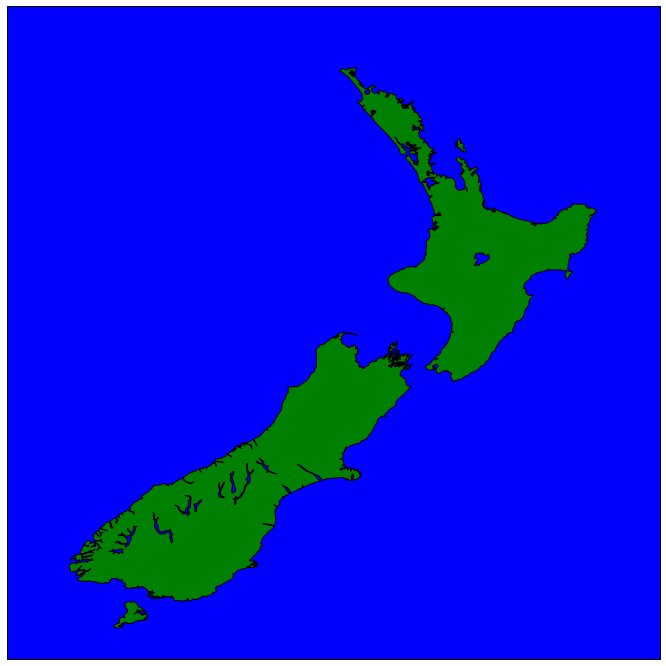

In [362]:
from mpl_toolkits.basemap import Basemap
# create new figure, axes instances.

plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-195,llcrnrlat=-48,urcrnrlon=-180,urcrnrlat=-33, resolution = 'i')

map.drawmapboundary(fill_color='blue')
#Fill the continents with the land color
map.fillcontinents(color='green',lake_color='blue')
map.drawcoastlines()
plt.show()

# Cool road names I came across

Erewhon
Stratford districts many shakespeare references (Falstaff, Prospero, Claudias, Juliet, Caesar)

# Misclassifications

Usually very "vowelly" words - panorama, horatio, protea
Quite a few spanish (Santa Maria) and native american words (Utah, Ontario(?))